# User Based Similarity

In [1]:
import os

import vaex
import numpy as np
import pandas as pd

In [13]:
%%time

ratings = vaex.read_csv('data/movie_ratings.csv', convert=True, chunk_size=1_000_000)
ratings = ratings[ratings['rating'] >= 3.5].extract()
ratings.drop(columns=['rating'], inplace=True)

movies = ratings.groupby(by='id', agg={'num_likes': vaex.agg.nunique('user')})

print(ratings.shape)
print(movies.shape)

(17130115, 2)
(15967, 2)
CPU times: user 10.3 s, sys: 1.33 s, total: 11.6 s
Wall time: 3.76 s


In [14]:
NUM_EVENTS = 500

prob = movies['num_likes'].values / movies['num_likes'].sum()

np.random.seed(0)
ids = np.random.choice(movies['id'].values, size=NUM_EVENTS, p=prob)

ratings = ratings[ratings['id'].isin(ids)].extract()

print(ratings.shape)

(4663188, 2)


In [15]:
%%time

likes_left = ratings.copy()
likes_left.rename('id', 'id_left')

likes_right = ratings.copy()
likes_right.rename('id', 'id_right')

movie_sim = likes_left.join(likes_right, on='user', allow_duplication=True)

print(movie_sim.shape)

(240550144, 3)
CPU times: user 37.3 s, sys: 12.3 s, total: 49.6 s
Wall time: 36.8 s


In [16]:
%%time

movie_sim = movie_sim[movie_sim['id_left'] != movie_sim['id_right']].extract()
print(movie_sim.shape)

(235886956, 3)
CPU times: user 6.54 s, sys: 2.11 s, total: 8.65 s
Wall time: 3.66 s


In [17]:
%%time

movie_sim = movie_sim.join(movies, left_on='id_left', right_on='id')
movie_sim.drop(columns=['id'], inplace=True)
movie_sim.rename('num_likes', 'num_likes_left')

movie_sim = movie_sim.join(movies, left_on='id_right', right_on='id')
movie_sim.drop(columns=['id'], inplace=True)
movie_sim.rename('num_likes', 'num_likes_right')

movie_sim.head()

CPU times: user 8.72 s, sys: 320 ms, total: 9.04 s
Wall time: 811 ms


#,user,id_left,id_right,num_likes_left,num_likes_right
0,4,6,1,20049,50939
1,4,10,1,16777,50939
2,4,16,1,15219,50939
3,4,25,1,15558,50939
4,4,32,1,40752,50939
5,4,41,1,3513,50939
6,4,47,1,45549,50939
7,4,95,1,8759,50939
8,4,110,1,53582,50939
9,4,141,1,14240,50939


In [18]:
%%time

agg_funs = {'num_likes_both':vaex.agg.count('user'), 'num_likes_left':vaex.agg.max('num_likes_left'), 'num_likes_right':vaex.agg.max('num_likes_right')}
movie_sim = movie_sim.groupby(by=['id_left','id_right'], agg=agg_funs)
movie_sim['similarity'] = movie_sim['num_likes_both'] / np.exp(0.5*np.log(movie_sim['num_likes_left']) + 0.5*np.log(movie_sim['num_likes_right']))
movie_sim.head()

CPU times: user 38.7 s, sys: 296 ms, total: 39 s
Wall time: 1.89 s


#,id_left,id_right,num_likes_both,num_likes_left,num_likes_right,similarity
0,356,1214,16879,77143,32325,0.33801
1,356,1217,2048,77143,4830,0.106098
2,356,1222,14265,77143,23343,0.336159
3,356,1230,6191,77143,15367,0.179812
4,356,1233,5986,77143,13257,0.187183
5,356,1240,18911,77143,32724,0.376386
6,356,1246,14438,77143,21614,0.353583
7,356,1262,6151,77143,10988,0.21127
8,356,1270,26850,77143,44345,0.459064
9,356,1394,6454,77143,12841,0.20506


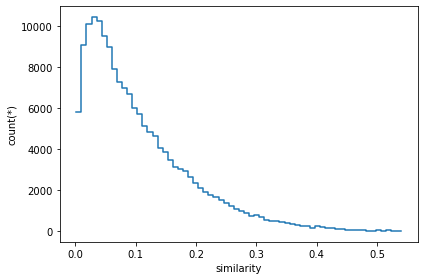

In [19]:
movie_sim.plot1d(movie_sim.similarity, limits='99.9%')

In [20]:
movie_sim_pd = movie_sim.to_pandas_df()
movie_sim_pd.sort_values(['id_left','similarity'], ascending=[True,False], inplace=True)
movie_sim_pd = movie_sim_pd.groupby('id_left').head(30)

print(movie_sim.shape)
print(movie_sim_pd.shape)

(166718, 6)
(12300, 6)


In [21]:
if not os.path.exists('output'):
    os.makedirs('output')

movie_sim_pd.to_csv('output/movie_similarity.csv', index=False)

In [22]:
movies_info = pd.read_csv('data/movie_info.csv', usecols=['id','title'])

high_sim = pd.merge(movie_sim_pd, movies_info, left_on='id_left', right_on='id')
high_sim.drop(columns=['id'], inplace=True)
high_sim.rename(columns={'title':'title_left'}, inplace=True)

high_sim = pd.merge(high_sim, movies_info, left_on='id_right', right_on='id')
high_sim.drop(columns=['id'], inplace=True)
high_sim.rename(columns={'title':'title_right'}, inplace=True)

display(high_sim[['id_left','title_left','title_right','similarity']].sort_values('similarity', ascending=False)
                                                                     .head(30))

,id_left,title_left,title_right,similarity
6056,5952,The Lord of the Rings: The Two Towers,The Lord of the Rings: The Fellowship of the Ring,0.831866
6224,4993,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Two Towers,0.831866
6525,5952,The Lord of the Rings: The Two Towers,The Lord of the Rings: The Return of the King,0.824041
6246,7153,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Two Towers,0.824041
6517,4993,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Return of the King,0.816243
6069,7153,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Fellowship of the Ring,0.816243
2175,260,Star Wars,The Empire Strikes Back,0.753279
1349,1196,The Empire Strikes Back,Star Wars,0.753279
2117,1196,The Empire Strikes Back,Return of the Jedi,0.722074
2205,1210,Return of the Jedi,The Empire Strikes Back,0.722074


In [23]:
display(high_sim.loc[high_sim['id_left']==4993, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
6224,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Two Towers,0.831866
6517,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Return of the King,0.816243
4459,The Lord of the Rings: The Fellowship of the Ring,Pirates of the Caribbean: The Curse of the Bla...,0.546327
3706,The Lord of the Rings: The Fellowship of the Ring,Fight Club,0.541024
4291,The Lord of the Rings: The Fellowship of the Ring,Shrek,0.530268
1838,The Lord of the Rings: The Fellowship of the Ring,Gladiator,0.528274
2275,The Lord of the Rings: The Fellowship of the Ring,The Empire Strikes Back,0.525910
1392,The Lord of the Rings: The Fellowship of the Ring,Star Wars,0.502728
6896,The Lord of the Rings: The Fellowship of the Ring,The Dark Knight,0.502115
2079,The Lord of the Rings: The Fellowship of the Ring,Raiders of the Lost Ark,0.488833


In [24]:
display(high_sim.loc[high_sim['id_left']==260, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
2175,Star Wars,The Empire Strikes Back,0.753279
2095,Star Wars,Return of the Jedi,0.702372
1963,Star Wars,Raiders of the Lost Ark,0.614297
1583,Star Wars,Indiana Jones and the Last Crusade,0.530317
3342,Star Wars,Back to the Future,0.507713
5998,Star Wars,The Lord of the Rings: The Fellowship of the Ring,0.502728
675,Star Wars,The Terminator,0.496144
1044,Star Wars,Alien,0.487180
6493,Star Wars,The Lord of the Rings: The Return of the King,0.483217
6183,Star Wars,The Lord of the Rings: The Two Towers,0.481655


In [25]:
display(high_sim.loc[high_sim['id_left']==296, ['title_left','title_right','similarity']]
                .sort_values('similarity', ascending=False)
                .head(10))

,title_left,title_right,similarity
804,Pulp Fiction,The Silence of the Lambs,0.613286
1414,Pulp Fiction,The Shawshank Redemption,0.590023
37,Pulp Fiction,Se7en,0.574013
3652,Pulp Fiction,Fight Club,0.557995
2586,Pulp Fiction,Forrest Gump,0.525298
195,Pulp Fiction,Fargo,0.518520
3544,Pulp Fiction,American Beauty,0.517062
3813,Pulp Fiction,Schindler's List,0.493973
284,Pulp Fiction,GoodFellas,0.492476
867,Pulp Fiction,The Godfather,0.491188
